## Compact binary inspirals from gravitational radiation reaction

In this example, we look at highly nonlinear dissipative forces arising in the orbital dynamics of compact binaries that are inspiraling due to the emission of gravitational waves. For demonstration purposes, we focus here on the leading order conservative and non-conservative forces in a post-Newtonian expansion in the binary's relative speed.

The conservative part, $L$, of the total Lagrangian, $\Lambda$, is given by
$$L = \frac{1}{2} \mu \dot{\bf q}^2 + \frac{ \mu M }{ | {\bf q}^2 | }$$
and the nonconservative part, $K$, by
$$K = \frac{16}{5} \nu^2 M^4 \frac{ \dot{\mathbf q}_+ \cdot {\mathbf q}_- }{ |{\mathbf q}_+|^4 } - \frac{48}{5} \nu^2 M^3 \frac{|\dot{\mathbf q}_+|^2 (\dot{\mathbf q}_+ \cdot {\mathbf q}_-) }{|{\mathbf q}_+|^3}$$
$$\qquad \qquad \qquad \qquad + 24 \nu^2 M^3 \frac{ (\dot{\mathbf q}_+ \cdot {\mathbf q}_+)^2 (\dot{\mathbf q}_+ \cdot {\mathbf q}_-) }{|{\mathbf q}_+|^5} + \frac{ 16 }{15} \nu^2 M^4 \frac{ (\dot{\mathbf q}_+ \cdot {\mathbf q}_+) ({\mathbf q}_+ \cdot {\mathbf q}_-) }{ |{\mathbf q}_+|^6 }$$
$$\qquad \qquad \qquad \qquad \qquad ~~~ + \frac{144}{5} \nu^2 M^3 \frac{|\dot{\mathbf q}_+|^2 (\dot{\mathbf q}_+ \cdot {\mathbf q}_+) ({\mathbf q}_+ \cdot {\mathbf q}_-)}{|{\mathbf q}_+|^5} - 40 \nu^2 M^3 \frac{(\dot{\mathbf q}_+ \cdot {\mathbf q}_+)^3 ({\mathbf q}_+ \cdot {\mathbf q}_-)}{|{\mathbf q}_+|^7} ~.$$

We work in units where $G=c=1$ and where the center-of-mass frame so that ${\bf q}$ is the relative separation vector in Cartesian coordinates. The quantities $\nu$ and $M$ are the symmetric mass ratio and total mass, respectively.

In [1]:
%matplotlib inline
import numpy as np, matplotlib.pyplot as plt
import orbit_util as orbit
import jax.numpy as jnp
from slimpletic import Solver

In [2]:
# Parameters of the compact binary

# One solar mass in seconds
G = 6.67428e-11  #(in m^3/kg/s^2)
c = 2.99792458e8  # (in m/s)
Msun_in_kg = 1.98892e30
Msun_in_sec = G / c ** 3 * Msun_in_kg
sec_to_km = c / 1000.

# Component masses
m1 = 1.4 * Msun_in_sec
m2 = 1.4 * Msun_in_sec

# Total mass
M = m1 + m2

# Symmetric mass ratio
nu = m1 * m2 / M ** 2

# Reduced mass
mu = nu * M

### Slimplectic integration

In [3]:
# Create an instance of the GalerkinGaussLobatto class and call it `pn` for post-Newtonian
# pn = slimplectic.GalerkinGaussLobatto('t', ['x', 'y'], ['vx', 'vy'])

In [4]:
def lagrangian(q, v, t):
    """Total Lagrangian for the binary"""
    return 0.5 * mu * jnp.dot(v, v) - mu * M / jnp.dot(q, q) ** 0.5


def nonconservative(qp, qm, vp, vm, t):
    return 16. / 5. * nu ** 2 * M ** 4 * jnp.dot(vp, qm) / jnp.dot(qp, qp) ** 2 \
        - 48. / 5. * nu ** 2 * M ** 3 * jnp.dot(vp, vp) * jnp.dot(vp, qm) / jnp.dot(qp, qp) ** 1.5 \
        + 24. * nu ** 2 * M ** 3 * jnp.dot(vp, qp) ** 2 * jnp.dot(vp, qm) / jnp.dot(qp, qp) ** 2.5 \
        + 16. / 15. * nu ** 2 * M ** 4 * jnp.dot(vp, qp) * jnp.dot(qp, qm) / jnp.dot(qp, qp) ** 3 \
        + 144. / 5. * nu ** 2 * M ** 3 * jnp.dot(vp, vp) * jnp.dot(vp, qp) * jnp.dot(qp, qm) / jnp.dot(qp, qp) ** 2.5 \
        - 40. * nu ** 2 * M ** 3 * jnp.dot(vp, qp) ** 3 * jnp.dot(qp, qm) / jnp.dot(qp, qp) ** 3.5

In [5]:
# Specify time samples at which the numerical solution is to be given initial data.
# We take data for a quasi-circular inspiral

q0 = np.array([100., 0.]) * M
v0 = np.asarray([-64. / 5. * nu * (M / q0[0]) ** 3, np.sqrt(M / q0[0])])
# (The initial velocity is found by calculating the leading correction 
#  to pure circular motion due to radiation reaction.)
pi0 = mu * v0

# Estimate time to "coalescence" when the orbital separation is zero
r0 = np.sqrt(q0[0] ** 2 + q0[1] ** 2)
tcoal = 5. / 256. / nu * (r0 / M) ** 4 * M

# Time samples at every 1000M
dt = 1000 * M
t_1000 = np.arange(0, tcoal + dt, dt)

In [6]:
pn = Solver(
    lagrangian=lagrangian,
    k_potential=nonconservative,
    r=1,
    dt=dt,
)

In [19]:
# Now integrate the 4th order slimplectic integrator
q_1000, pi_1000 = pn.integrate(jnp.array(q0), jnp.array(pi0), t_1000[0], t_1000.size - 1)
q_1000 = q_1000.T
pi_1000 = pi_1000.T

Let's plot this numerical solution with the analytical solution obtained by applying the adiabatic approximation to the same equations of motion. In the adiabatic approximation, one evaluates the radiation reaction forces (derived from $K$) on a sequence of circular orbits, ignoring the contribution from the radial velocity. The adiabatic approximation gives the following expressions for the orbital separation and phase 
$$r_{\rm ad}(t) = \left( r_0^4 - \frac{ 256  }{ 5 } \nu M^3 t \right)^{\!1/4}$$

$$\phi_{\rm ad}(t)  = \frac{ r_0^{5/2} - r_{\rm ad}^{5/2}(t)  }{32 \nu M^{5/2} }$$

so that the Cartesian components of the relative orbital motion are 
$$\big( r_{\rm ad}(t) \cos \phi_{\rm ad}(t), r_{\rm ad}(t) \sin \phi_{\rm ad} (t), 0 \big) .$$ The quantity $r_0$ is the initial separation and the initial orbital phase is taken to be zero.

In [20]:
# Analytical solution from the adiabatic approximation
def r_ad(time):
    """Orbital separation from the adiabatic approximation"""
    return np.abs(r0 ** 4 - 256. / 5. * nu * M ** 3 * time) ** 0.25


def phi_ad(time):
    """Orbital phase from the adiabatic approximation"""
    return (r0 ** 2.5 - r_ad(time) ** 2.5) / (32. * nu * M ** 2.5)


def rdot_ad(time):
    """Time derivative of radial separation, r_ad(t)"""
    return - 256. / 5. * M ** 3 * nu / 4 / r_ad(time) ** 3


def omega_ad(time):
    """Orbital angular frequency from the adiabatic approximation"""
    return np.sqrt(M) / r_ad(time) ** 1.5


def q_ad(time):
    """Orbital separation vector in Cartesian coordinates"""
    return r_ad(time) * np.cos(phi_ad(time)), r_ad(time) * np.sin(phi_ad(time))


def v_ad(time):
    """Orbital velocity vector in Cartesian coordinates"""
    return rdot_ad(time) * np.cos(phi_ad(time)) - omega_ad(time) * r_ad(time) * np.sin(phi_ad(time)), \
           rdot_ad(time) * np.sin(phi_ad(time)) + omega_ad(time) * r_ad(time) * np.cos(phi_ad(time))

Text(0, 0.5, 'Orbital separation, $r$ [km]')

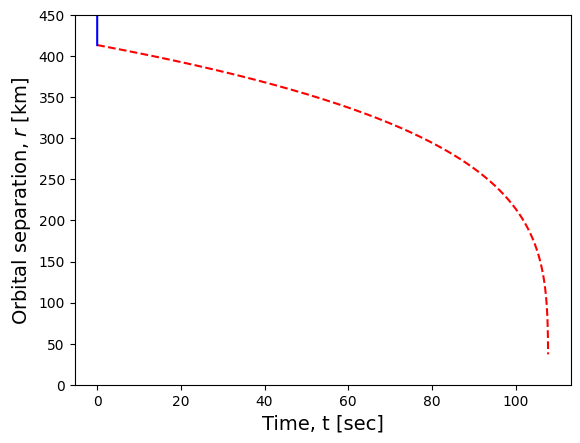

In [22]:
# Plot the numerical and analyatical orbital separations
r_1000 = np.sqrt(q_1000[0] ** 2 + q_1000[1] ** 2)

plt.plot(t_1000, r_ad(t_1000) * sec_to_km, 'r--')
plt.plot(t_1000, r_1000 * sec_to_km, 'b-')
plt.ylim(0, 450)
plt.xlabel('Time, t [sec]', fontsize=14)
plt.ylabel('Orbital separation, $r$ [km]', fontsize=14)

The numerical solution clearly becomes unstable. The reason is because eventually the period of the orbit becomes comparable to or smaller than the time-step, $dt$, of $1000M$. One can show that adaptive time-step methods are better-suited to this problem, which is what we are exploring currently. 

For fixed time-steppers, we can take $dt$ to be increasingly smaller. We'll show how the solution changes with step-size but keeping the integration order fixed (at 4th). In particular, we take $dt$ to be the orbital period of the binary near the innermost stable circular orbit (ISCO). 

(WARNING: Integrating this higher-resolution run may take a few minutes to complete.)

In [26]:
# Time samples with increment given by the approximate orbital period at ISCO
T_isco = 6. ** 1.5 * (2. * np.pi * M)
t_isco = np.arange(0, tcoal + T_isco, T_isco)

# ...and integrate
q_isco, pi_isco = pn.integrate(q0, pi0, t0=t_isco[0], iterations=t_isco.size - 1)
q_isco = q_isco.T
pi_isco = pi_isco.T

Comparing this higher resolution solution with the adiabatic approximation gives much better agreement.

Text(0, 0.5, 'Orbital separation, $r$ [km]')

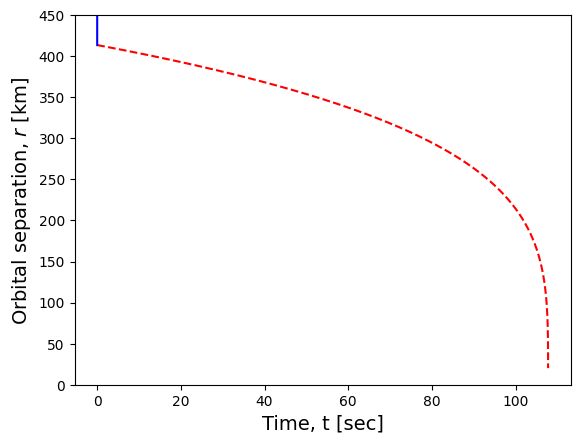

In [29]:
# Plot the numerical and analyatical orbital separations
r_isco = np.sqrt(q_isco[0] ** 2 + q_isco[1] ** 2)

plt.plot(t_isco, r_ad(t_isco) * sec_to_km, 'r--')
plt.plot(t_isco, r_isco * sec_to_km, 'b-')
plt.ylim(0, 450)
plt.xlabel('Time, t [sec]', fontsize=14)
plt.ylabel('Orbital separation, $r$ [km]', fontsize=14)

### Runge-Kutta integration

Generate the 4th order Runge-Kutta solutions at increments of $1000M$ and the orbital period at ISCO to compare below with output from the slimplectic integrators.

In [32]:
from example_notebooks.rk import RungeKutta4

# Instantiate the 4th order Runge-Kutta class
rk4 = RungeKutta4()


# Define the derivative operator for leading order radiation reaction in the PN expansion
def dydt(time, y):
    deriv = np.zeros(4)
    [q_x, q_y, v_x, v_y] = y
    r2 = (q_x * q_x + q_y * q_y)
    v2 = (v_x * v_x + v_y * v_y)
    vdotq = v_x * q_x + v_y * q_y
    deriv[0] = v_x
    deriv[1] = v_y
    deriv[2] = -M * mu * q_x / r2 ** 1.5
    deriv[2] += 16. / 5. * nu ** 2 * M ** 4 * v_x / r2 ** 2 \
                - 48. / 5. * nu ** 2 * M ** 3 * v2 * v_x / r2 ** 1.5 \
                + 24. * nu ** 2 * M ** 3 * vdotq ** 2 * v_x / r2 ** 2.5 \
                + 16. / 15. * nu ** 2 * M ** 4 * vdotq * q_x / r2 ** 3 \
                + 144. / 5. * nu ** 2 * M ** 3 * v2 * vdotq * q_x / r2 ** 2.5 \
                - 40. * nu ** 2 * M ** 3 * vdotq ** 3 * q_x / r2 ** 3.5
    deriv[2] /= mu

    deriv[3] = -mu * M * q_y / r2 ** 1.5
    deriv[3] += 16. / 5. * nu ** 2 * M ** 4 * v_y / r2 ** 2 \
                - 48. / 5. * nu ** 2 * M ** 3 * v2 * v_y / r2 ** 1.5 \
                + 24. * nu ** 2 * M ** 3 * vdotq ** 2 * v_y / r2 ** 2.5 \
                + 16. / 15. * nu ** 2 * M ** 4 * vdotq * q_y / r2 ** 3 \
                + 144. / 5. * nu ** 2 * M ** 3 * v2 * vdotq * q_y / r2 ** 2.5 \
                - 40. * nu ** 2 * M ** 3 * vdotq ** 3 * q_y / r2 ** 3.5
    deriv[3] /= mu

    return deriv


# Integrate
q_1000_rk4, v_1000_rk4 = rk4.integrate(q0, v0, t_1000, dydt)
q_isco_rk4, v_isco_rk4 = rk4.integrate(q0, v0, t_isco, dydt)

# Please note that q and pi are outputs of the slimplectic integration, 
# while q and v are output from the Runge-Kutta integrators.

### Comparison plots

Plot the orbital separation for the 4th order slimplectic and RK integrators for the numerical solutions generated at increments in time of $1000M$ and the orbital period at ISCO, respectively.

In [33]:
# Orbital separations from integrator outputs
r_1000 = np.sqrt(q_1000[0] ** 2 + q_1000[1] ** 2)
r_Tisco = np.sqrt(q_isco[0] ** 2 + q_isco[1] ** 2)
r_1000_rk4 = np.sqrt(q_1000_rk4[0] ** 2 + q_1000_rk4[1] ** 2)
r_isco_rk4 = np.sqrt(q_isco_rk4[0] ** 2 + q_isco_rk4[1] ** 2)

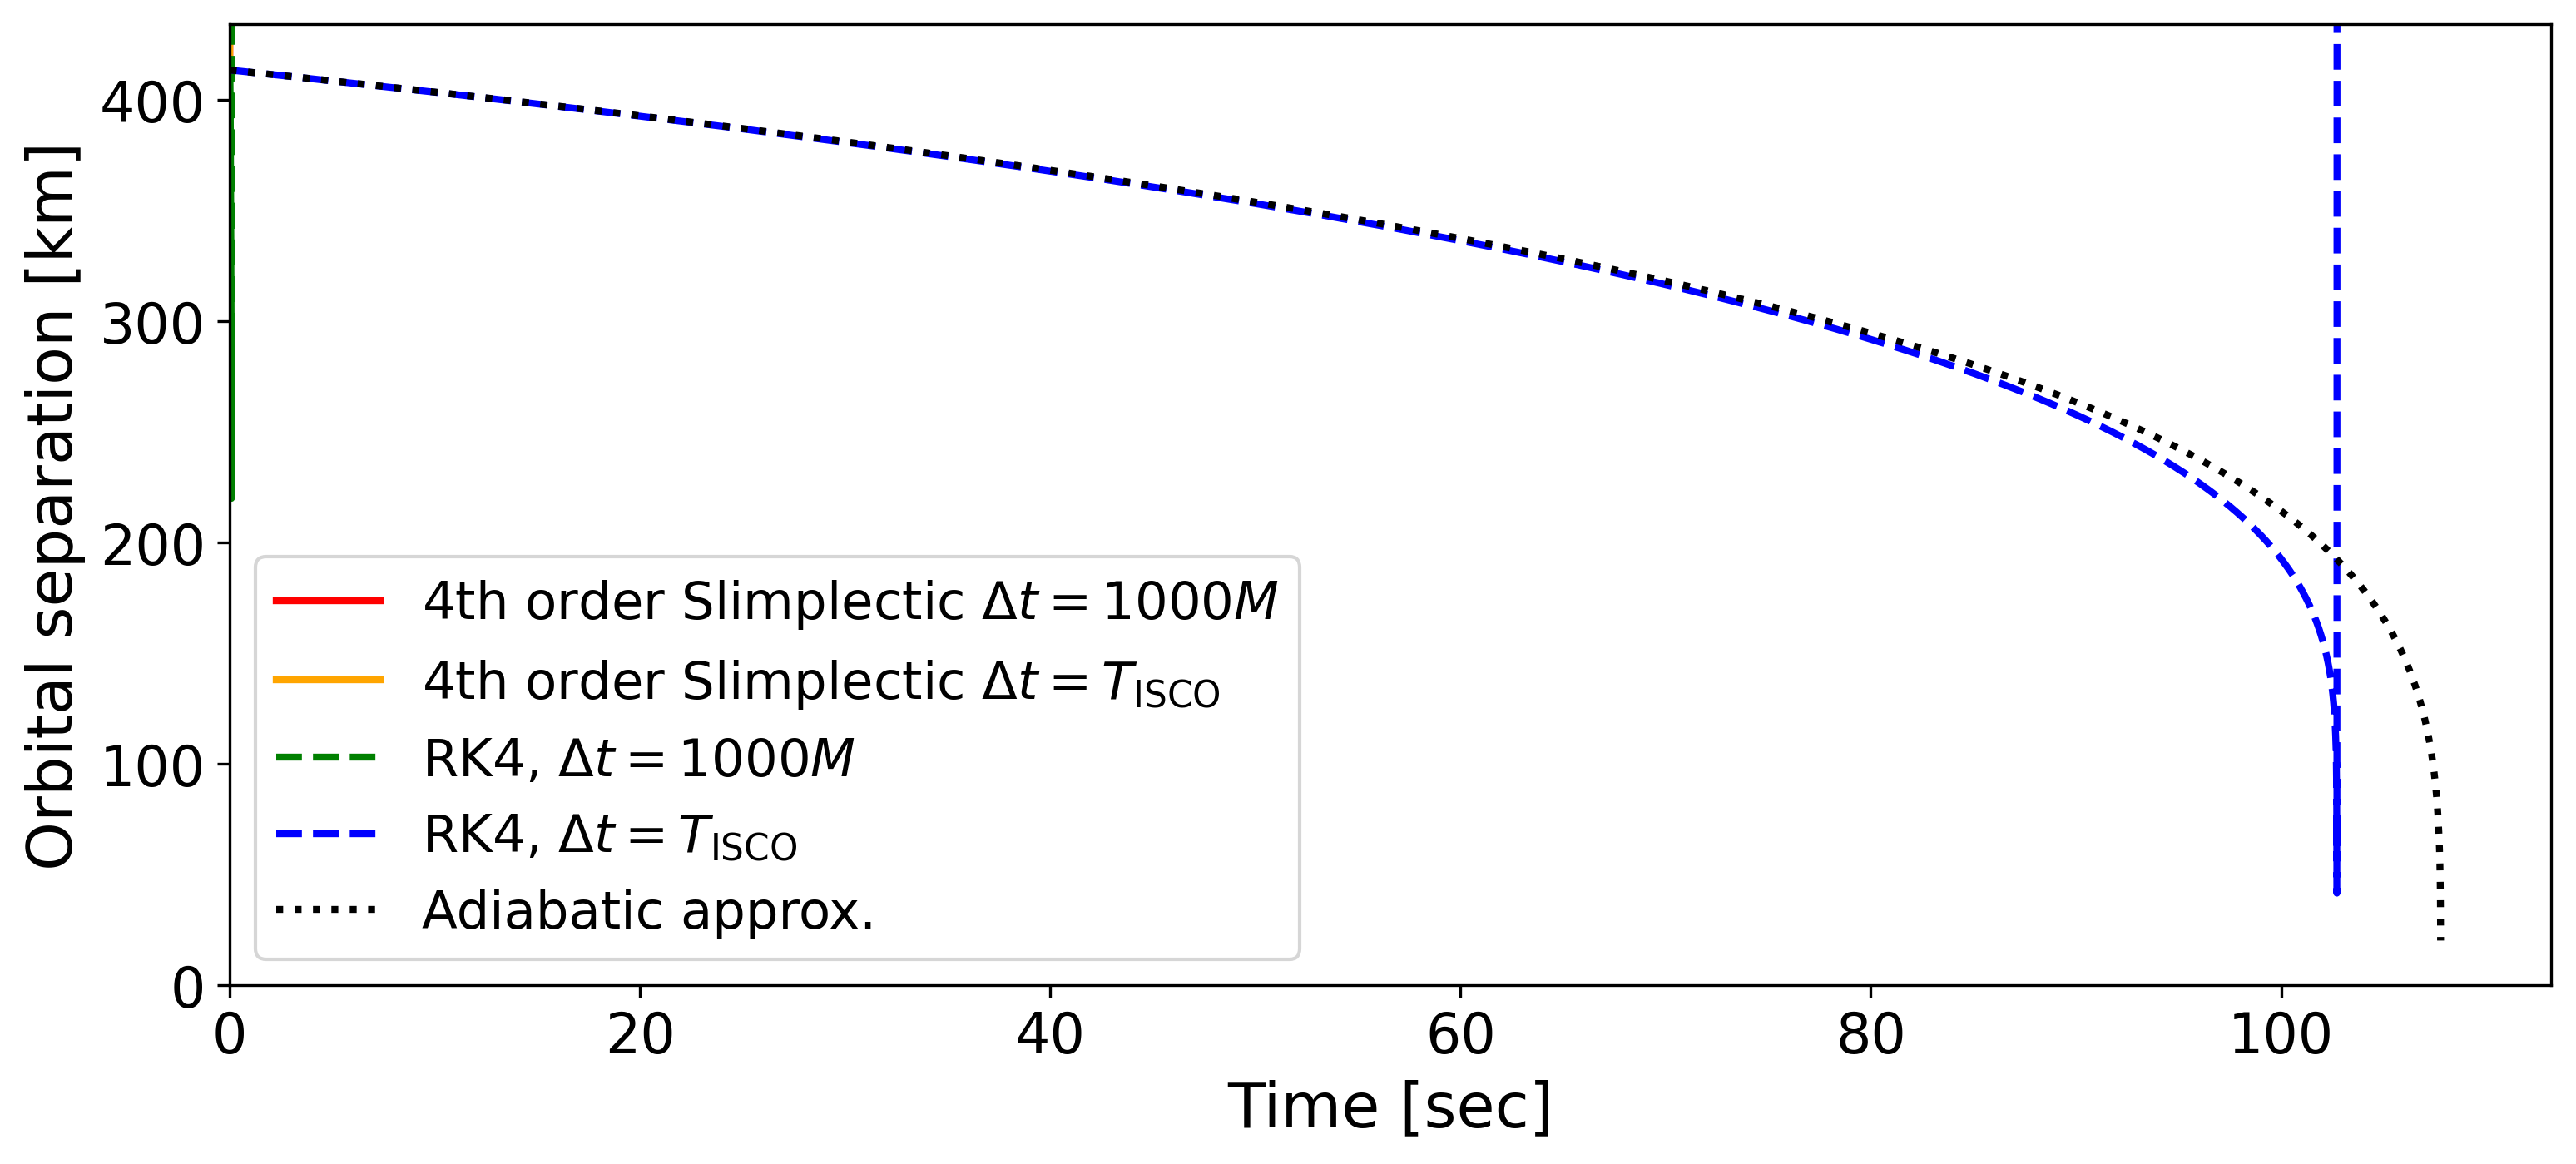

In [34]:
fig1 = plt.figure(figsize=(12, 5), dpi=300)
ax1 = fig1.add_subplot(111)

ax1.plot(t_1000, r_1000 * sec_to_km, 'r-', linewidth=2.0, rasterized=True,
         label='4th order Slimplectic $\Delta t=1000M$');
ax1.plot(t_isco, r_isco * sec_to_km, '-', color='orange', linewidth=2.0, rasterized=True,
         label='4th order Slimplectic $\Delta t=T_{\\rm ISCO}$');
ax1.plot(t_1000, r_1000_rk4 * sec_to_km, 'g--', linewidth=2.0, rasterized=True, label='RK4, $\Delta t=1000M$');
ax1.plot(t_isco, r_isco_rk4 * sec_to_km, 'b--', linewidth=2.0, rasterized=True, label='RK4, $\Delta t =T_{\\rm ISCO}$');

ax1.plot(t_isco, r_ad(t_isco) * sec_to_km, 'k:', linewidth=2.0, rasterized=True, label='Adiabatic approx.');
ax1.set_xlim(0, 1.05 * tcoal);
ax1.set_ylim(0, 1.05 * r0 * sec_to_km);
ax1.set_xlabel('Time [sec]', fontsize=18);
ax1.set_ylabel('Orbital separation [km]', fontsize=18);
ax1.legend(loc='lower left', prop={'size': 15});

ax1.tick_params(axis='both', which='major', labelsize=16)

Next, plot the fractional error in the orbital separation comparing the numerical solutions to the analytic adiabatic approximation. The errors in the slimplectic integration arise because the adiabatic approximation is breaking down towards the end of the inspiral.

/var/folders/7t/7cmj88216yq46yv_dg9r448w0000gn/T/ipykernel_13375/1445552297.py:15: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax2.set_xlim(0, 1.05 * tcoal);


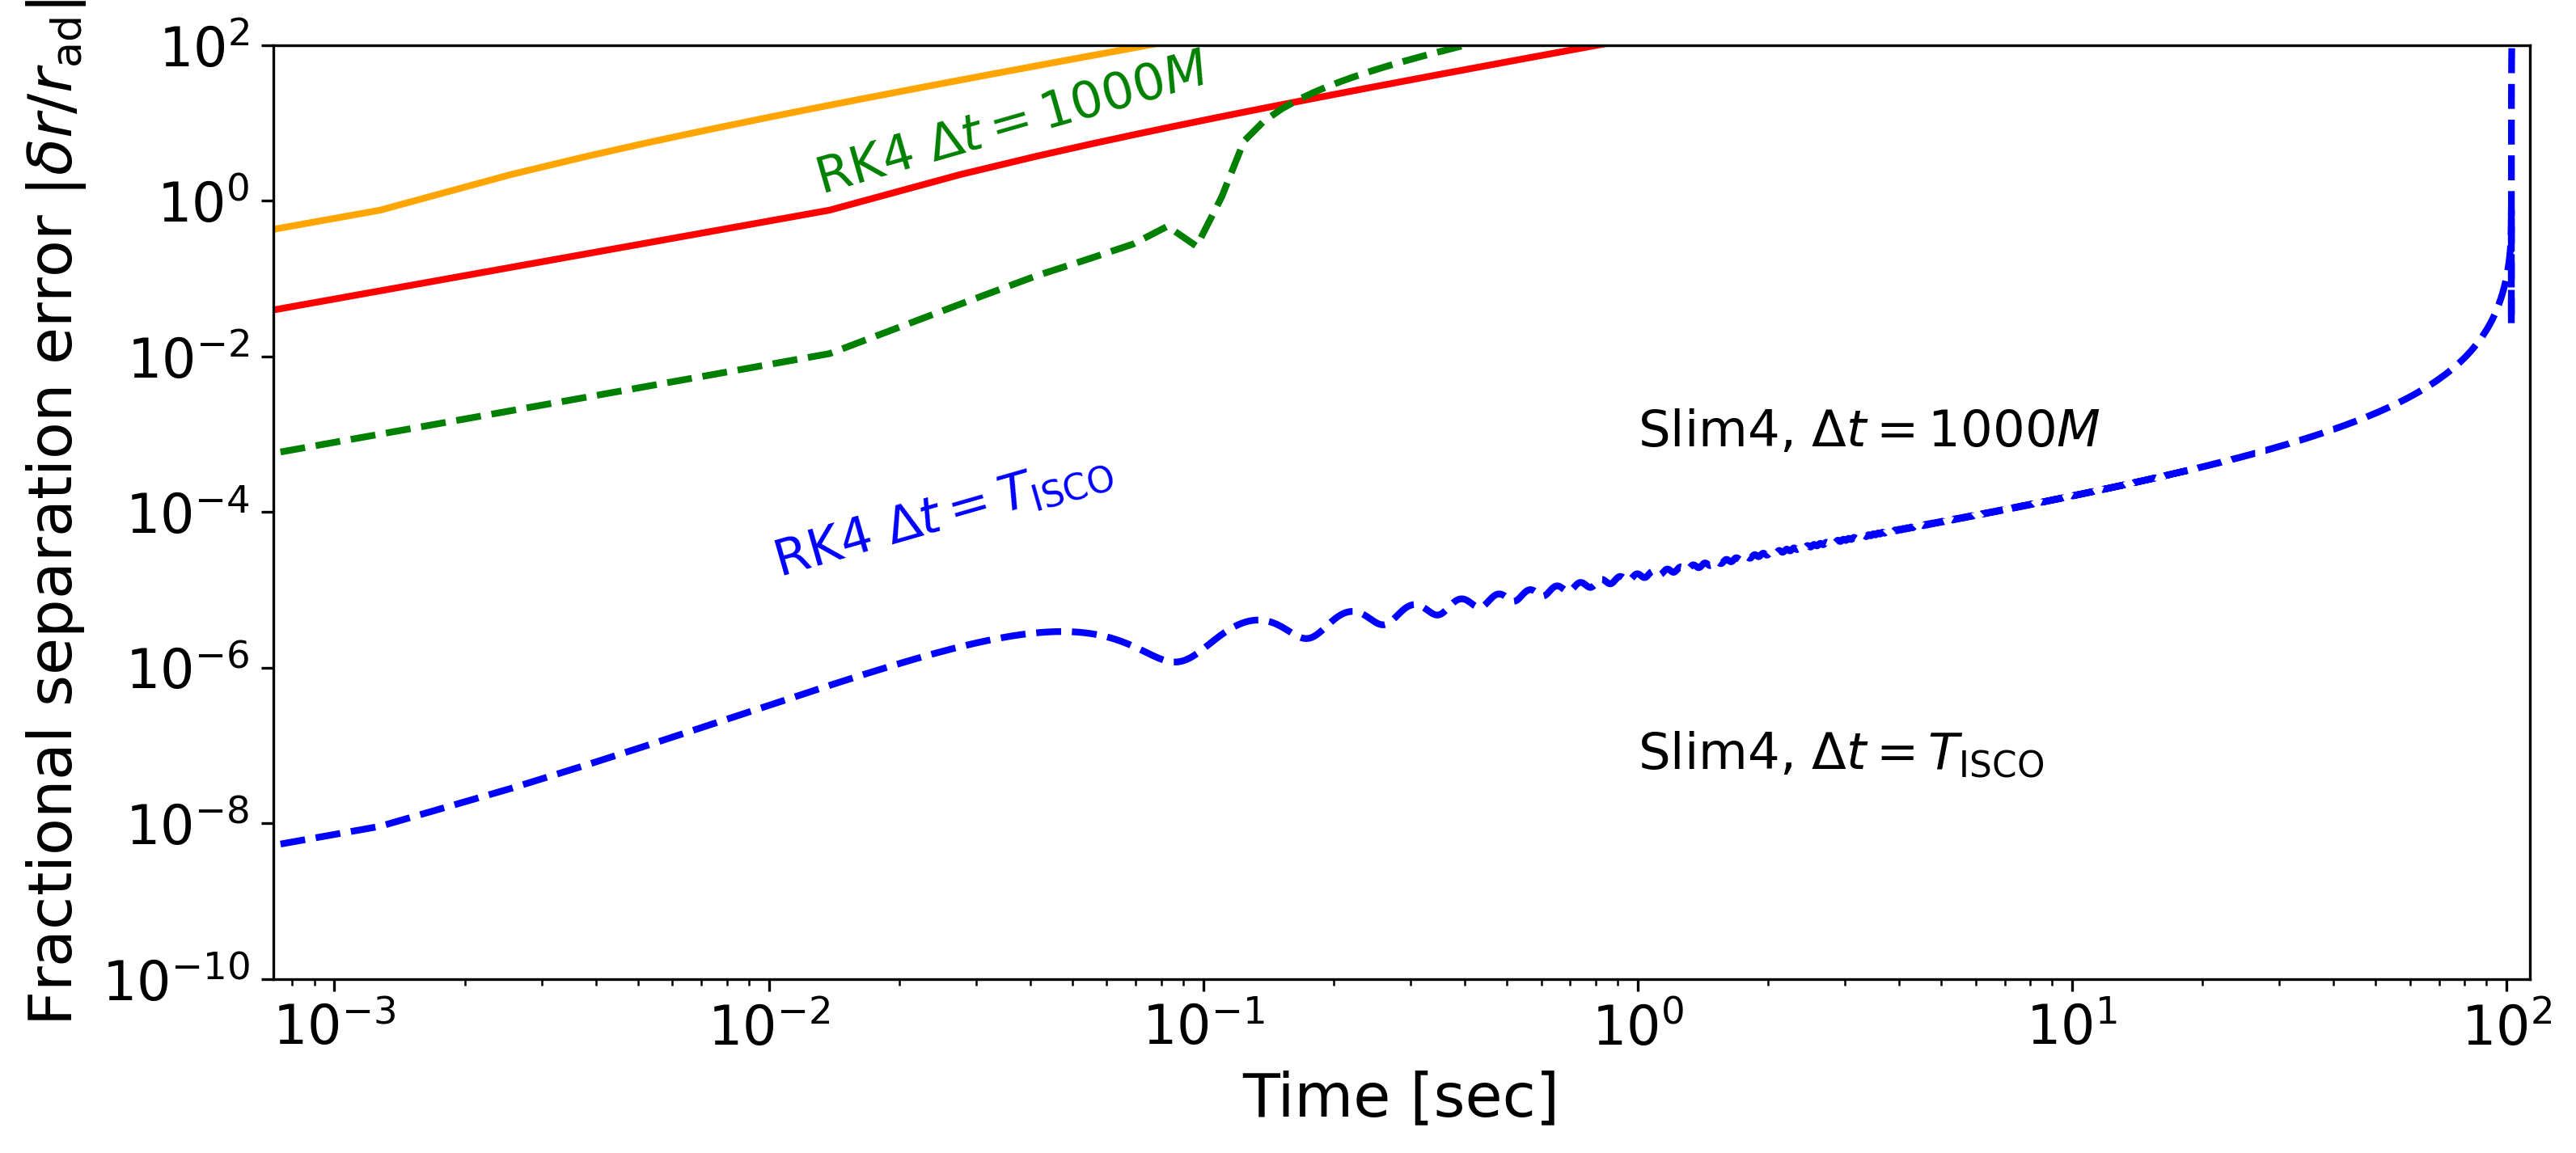

In [35]:
fig2 = plt.figure(figsize=(12, 5), dpi=300)
ax2 = fig2.add_subplot(111)

ax2.loglog(t_1000, np.abs(r_1000 / r_ad(t_1000) - 1.), 'r-', linewidth=2.0, rasterized=True);
ax2.loglog(t_isco, np.abs(r_isco / r_ad(t_isco) - 1.), '-', color='orange', linewidth=2.0, rasterized=True);
ax2.loglog(t_1000, np.abs(r_1000_rk4 / r_ad(t_1000) - 1.), 'g--', linewidth=2.0, rasterized=True);
ax2.loglog(t_isco, np.abs(r_isco_rk4 / r_ad(t_isco) - 1.), 'b--', linewidth=2.0, rasterized=True);

ax2.text(1, 7e-4, r'Slim4, $\Delta t = 1000M$', fontsize=15, color='black')
ax2.text(1, 5e-8, r'Slim4, $\Delta t = T_{\rm ISCO}$', fontsize=15, color='black')

ax2.text(0.0125, 1.25e0, r'RK4 $\Delta t = 1000M$', fontsize=15, color='green', rotation=16)
ax2.text(0.01, 1.5e-5, r'RK4 $\Delta t = T_{\rm ISCO}$', fontsize=15, color='blue', rotation=16)

ax2.set_xlim(0, 1.05 * tcoal);
ax2.set_ylim(1e-10, 1e2)
ax2.set_xlabel('Time [sec]', fontsize=18);
ax2.set_ylabel('Fractional separation error $|\delta r/ r_{\\rm ad}|$', fontsize=18);

ax2.set_yticks([1e-10, 1e-8, 1e-6, 1e-4, 1e-2, 1e0, 1e2])
ax2.tick_params(axis='both', which='major', labelsize=16)

Similar plots can be made for the orbital phase.

In [36]:
# Orbital phases
phi_1000 = orbit.phase(*q_1000)
phi_isco = orbit.phase(*q_isco)
phi_1000_rk4 = orbit.phase(*q_1000_rk4)
phi_isco_rk4 = orbit.phase(*q_isco_rk4)

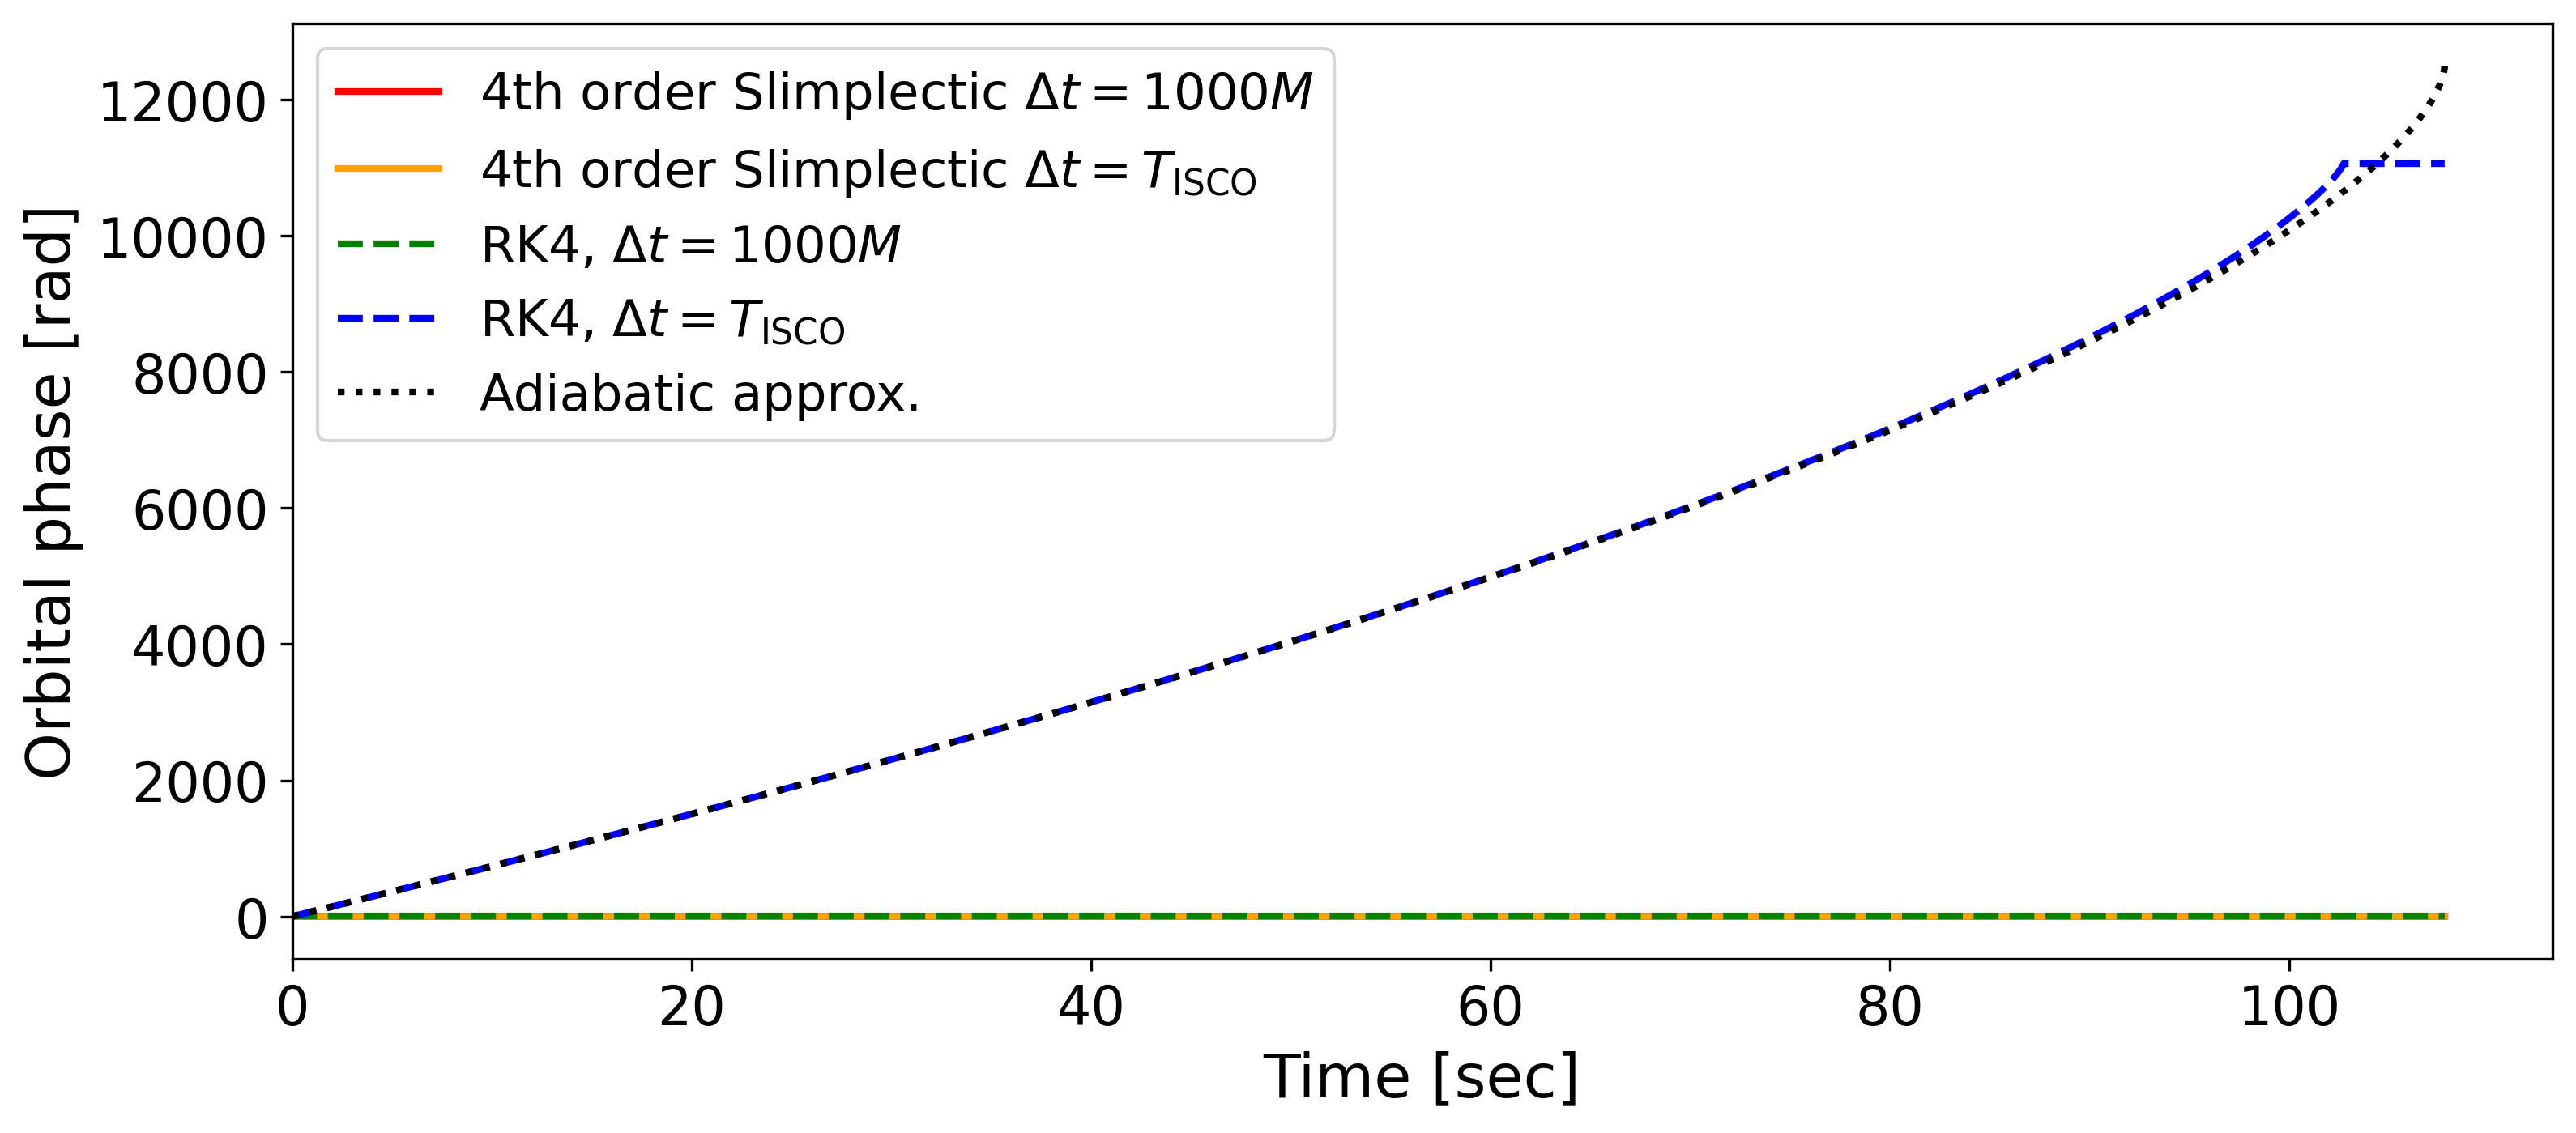

In [37]:
fig3 = plt.figure(figsize=(12, 5), dpi=300)
ax3 = fig3.add_subplot(111)

ax3.plot(t_1000, phi_1000, 'r-', linewidth=2.0, rasterized=True, label='4th order Slimplectic $\Delta t=1000M$');
ax3.plot(t_isco, phi_isco, '-', color='orange', linewidth=2.0, rasterized=True,
         label='4th order Slimplectic $\Delta t=T_{\\rm ISCO}$');
ax3.plot(t_1000, phi_1000_rk4, 'g--', linewidth=2.0, rasterized=True, label='RK4, $\Delta t=1000M$');
ax3.plot(t_isco, phi_isco_rk4, 'b--', linewidth=2.0, rasterized=True, label='RK4, $\Delta t =T_{\\rm ISCO}$');

ax3.plot(t_isco, phi_ad(t_isco), 'k:', linewidth=2.0, rasterized=True, label='Adiabatic approx.');
ax3.set_xlim(0, 1.05 * tcoal);
ax3.set_xlabel('Time [sec]', fontsize=18);
ax3.set_ylabel('Orbital phase [rad]', fontsize=18);
ax3.legend(loc='upper left', prop={'size': 15});

ax3.tick_params(axis='both', which='major', labelsize=16)

/var/folders/7t/7cmj88216yq46yv_dg9r448w0000gn/T/ipykernel_13375/3266787388.py:15: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax4.set_xlim(0, 1.05 * tcoal);


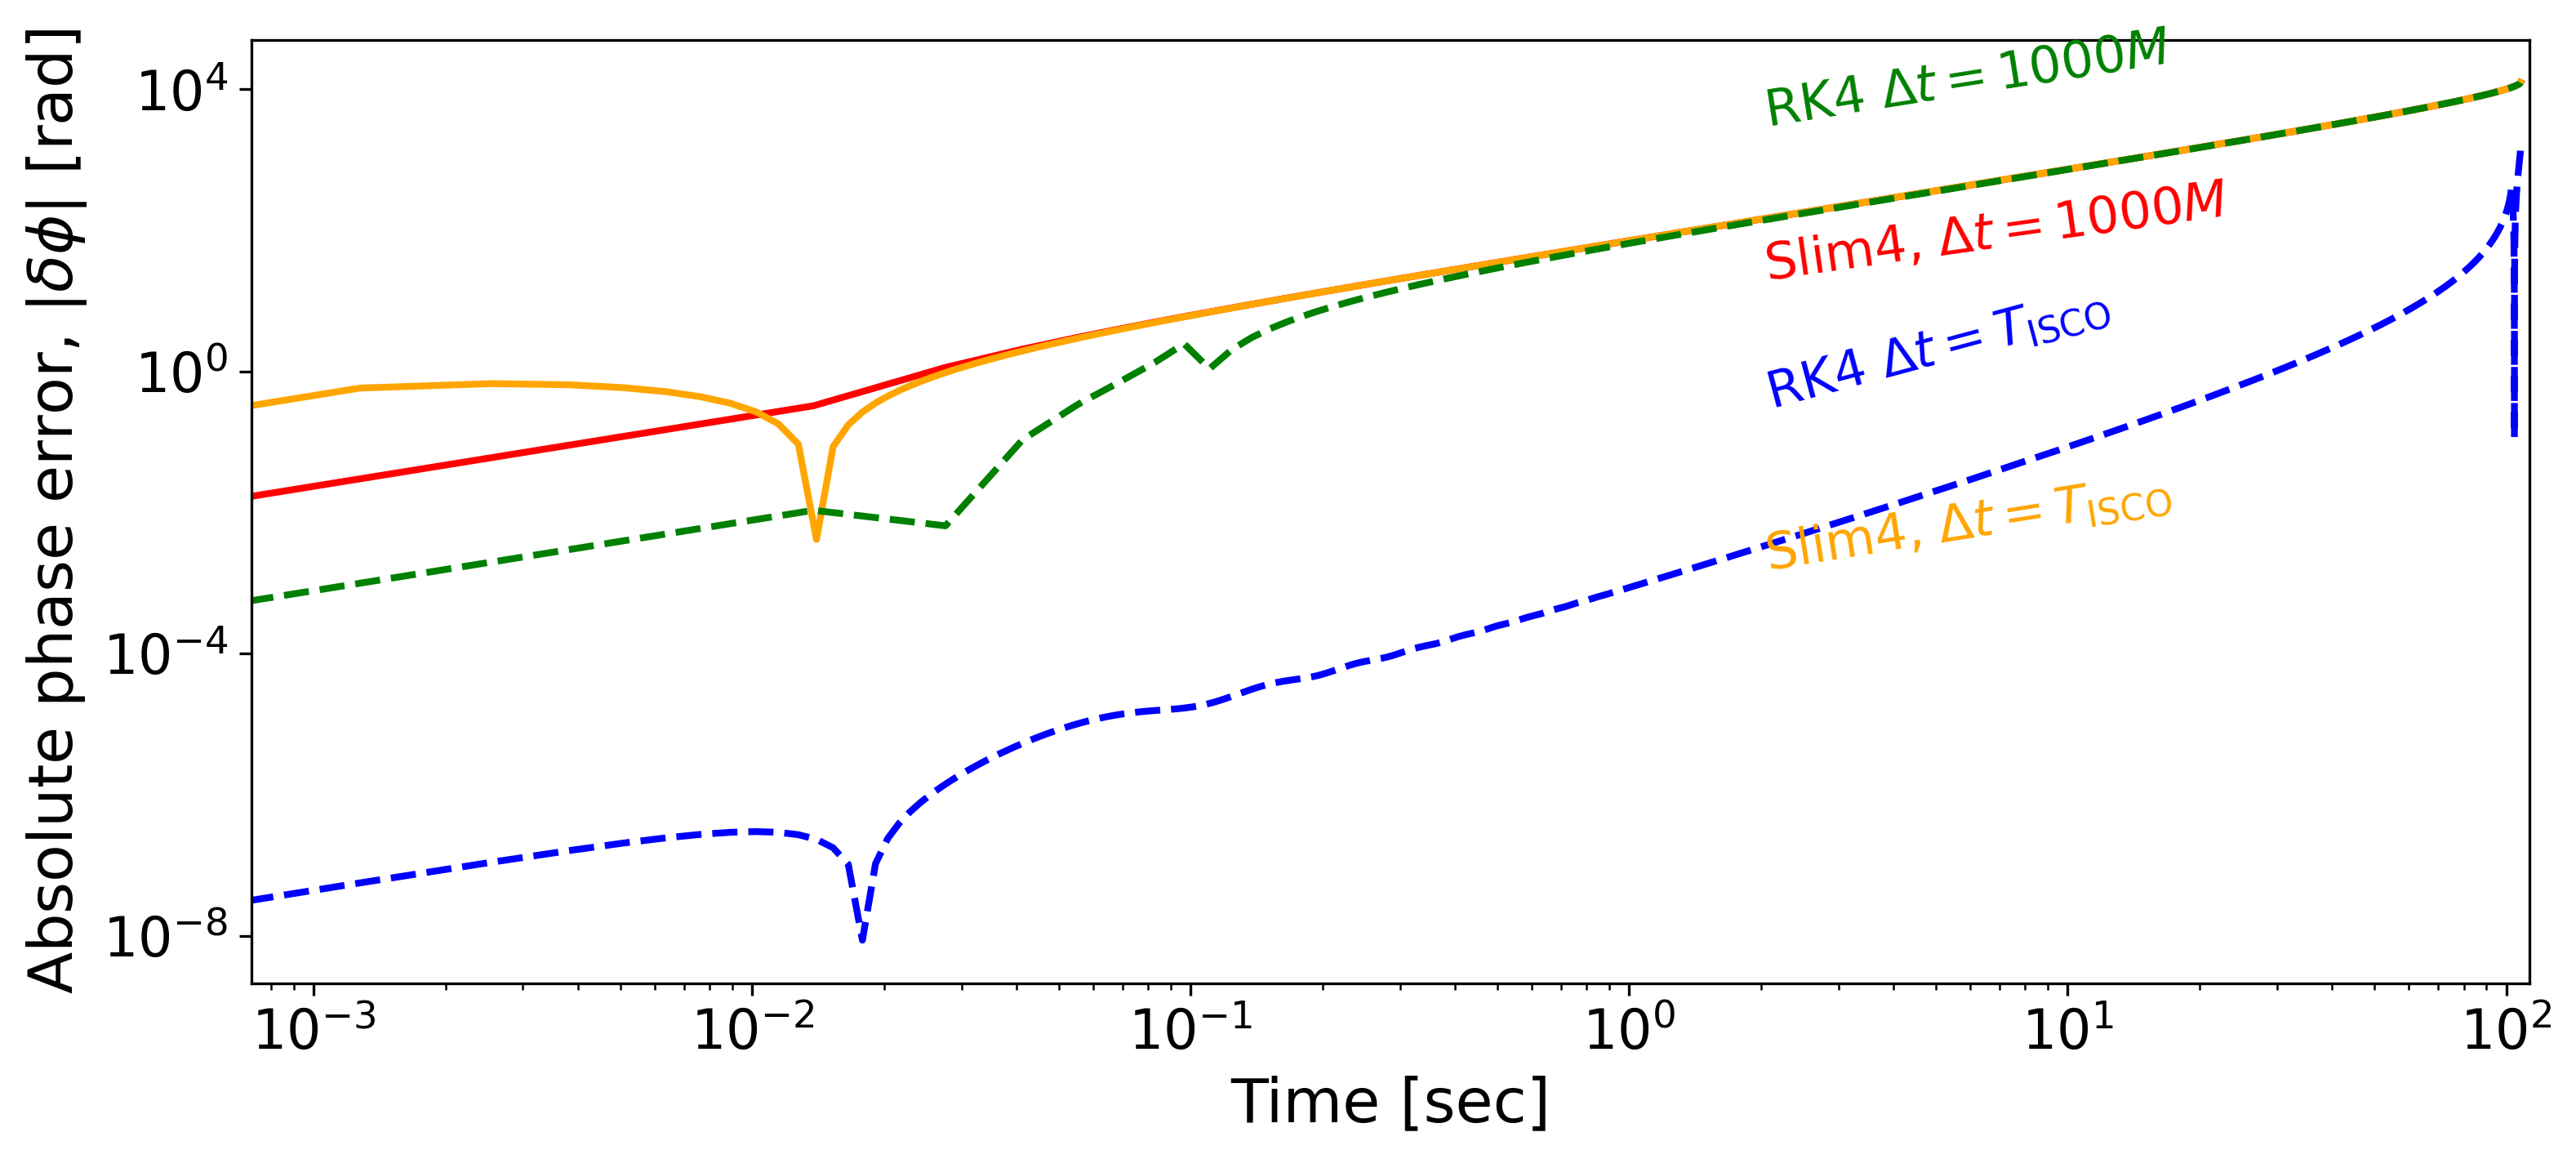

In [38]:
fig4 = plt.figure(figsize=(12, 5), dpi=300)
ax4 = fig4.add_subplot(111)

ax4.loglog(t_1000, np.abs(phi_1000 - phi_ad(t_1000)), 'r-', linewidth=2.0, rasterized=True);
ax4.loglog(t_isco, np.abs(phi_isco - phi_ad(t_isco)), '-', color='orange', linewidth=2.0, rasterized=True);
ax4.loglog(t_1000, np.abs(phi_1000_rk4 - phi_ad(t_1000)), 'g--', linewidth=2.0, rasterized=True);
ax4.loglog(t_isco, np.abs(phi_isco_rk4 - phi_ad(t_isco)), 'b--', linewidth=2.0, rasterized=True);

ax4.text(2, 2e1, r'Slim4, $\Delta t = 1000M$', fontsize=15, color='r', rotation=8)
ax4.text(2, 1.5e-3, r'Slim4, $\Delta t = T_{\rm ISCO}$', fontsize=15, color='orange', rotation=9)

ax4.text(2, 3e3, r'RK4 $\Delta t = 1000M$', fontsize=15, color='green', rotation=9)
ax4.text(2, 3e-1, r'RK4 $\Delta t = T_{\rm ISCO}$', fontsize=15, color='blue', rotation=15)

ax4.set_xlim(0, 1.05 * tcoal);
ax4.set_yticks([1e-8, 1e-4, 1, 1e4]);
ax4.tick_params(axis='both', which='major', labelsize=16)
ax4.set_xlabel('Time [sec]', fontsize=18);
ax4.set_ylabel('Absolute phase error, $|\delta \phi|$ [rad]', fontsize=18);

Let's see how the orbit's energy changes with time according to the different integration schemes and time increments. The energy is
$$E = \frac{1}{2} \mu \dot{\mathbf q}^2 - \frac{\mu M}{ |{\mathbf q}^2|} $$
and changes in time according to Einstein's quadrupole formula (when time-averaging over the orbital period).

To quantify the errors incurred by discretization and subsequent numerical integration, we define the fractional or relative energy difference as $\delta E / E = ( E_X - E )/ E$ where $E_X$ is the energy as measured by case $X$ with $X \in \{ {\rm Slim\_1000,~Slim\_ISCO,~RK4\_1000,~RK4\_ISCO} \}$.

In [39]:
# Energy function
def Energy(q, v):
    return 0.5 * mu * (v[0] ** 2 + v[1] ** 2) - mu * M / np.sqrt(q[0] ** 2 + q[1] ** 2)


# Energies from the analytic adiabatic approximation and from different integrators
E_1000_ad = Energy(q_ad(t_1000), v_ad(t_1000))
E_isco_ad = Energy(q_ad(t_isco), v_ad(t_isco))

E_1000 = Energy(q_1000, pi_1000 / mu)
E_isco = Energy(q_isco, pi_isco / mu)

E_1000_rk4 = Energy(q_1000_rk4, v_1000_rk4)
E_isco_rk4 = Energy(q_isco_rk4, v_isco_rk4)

/var/folders/7t/7cmj88216yq46yv_dg9r448w0000gn/T/ipykernel_13375/637745302.py:21: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax5.set_xlim(0, 1.02 * tcoal)


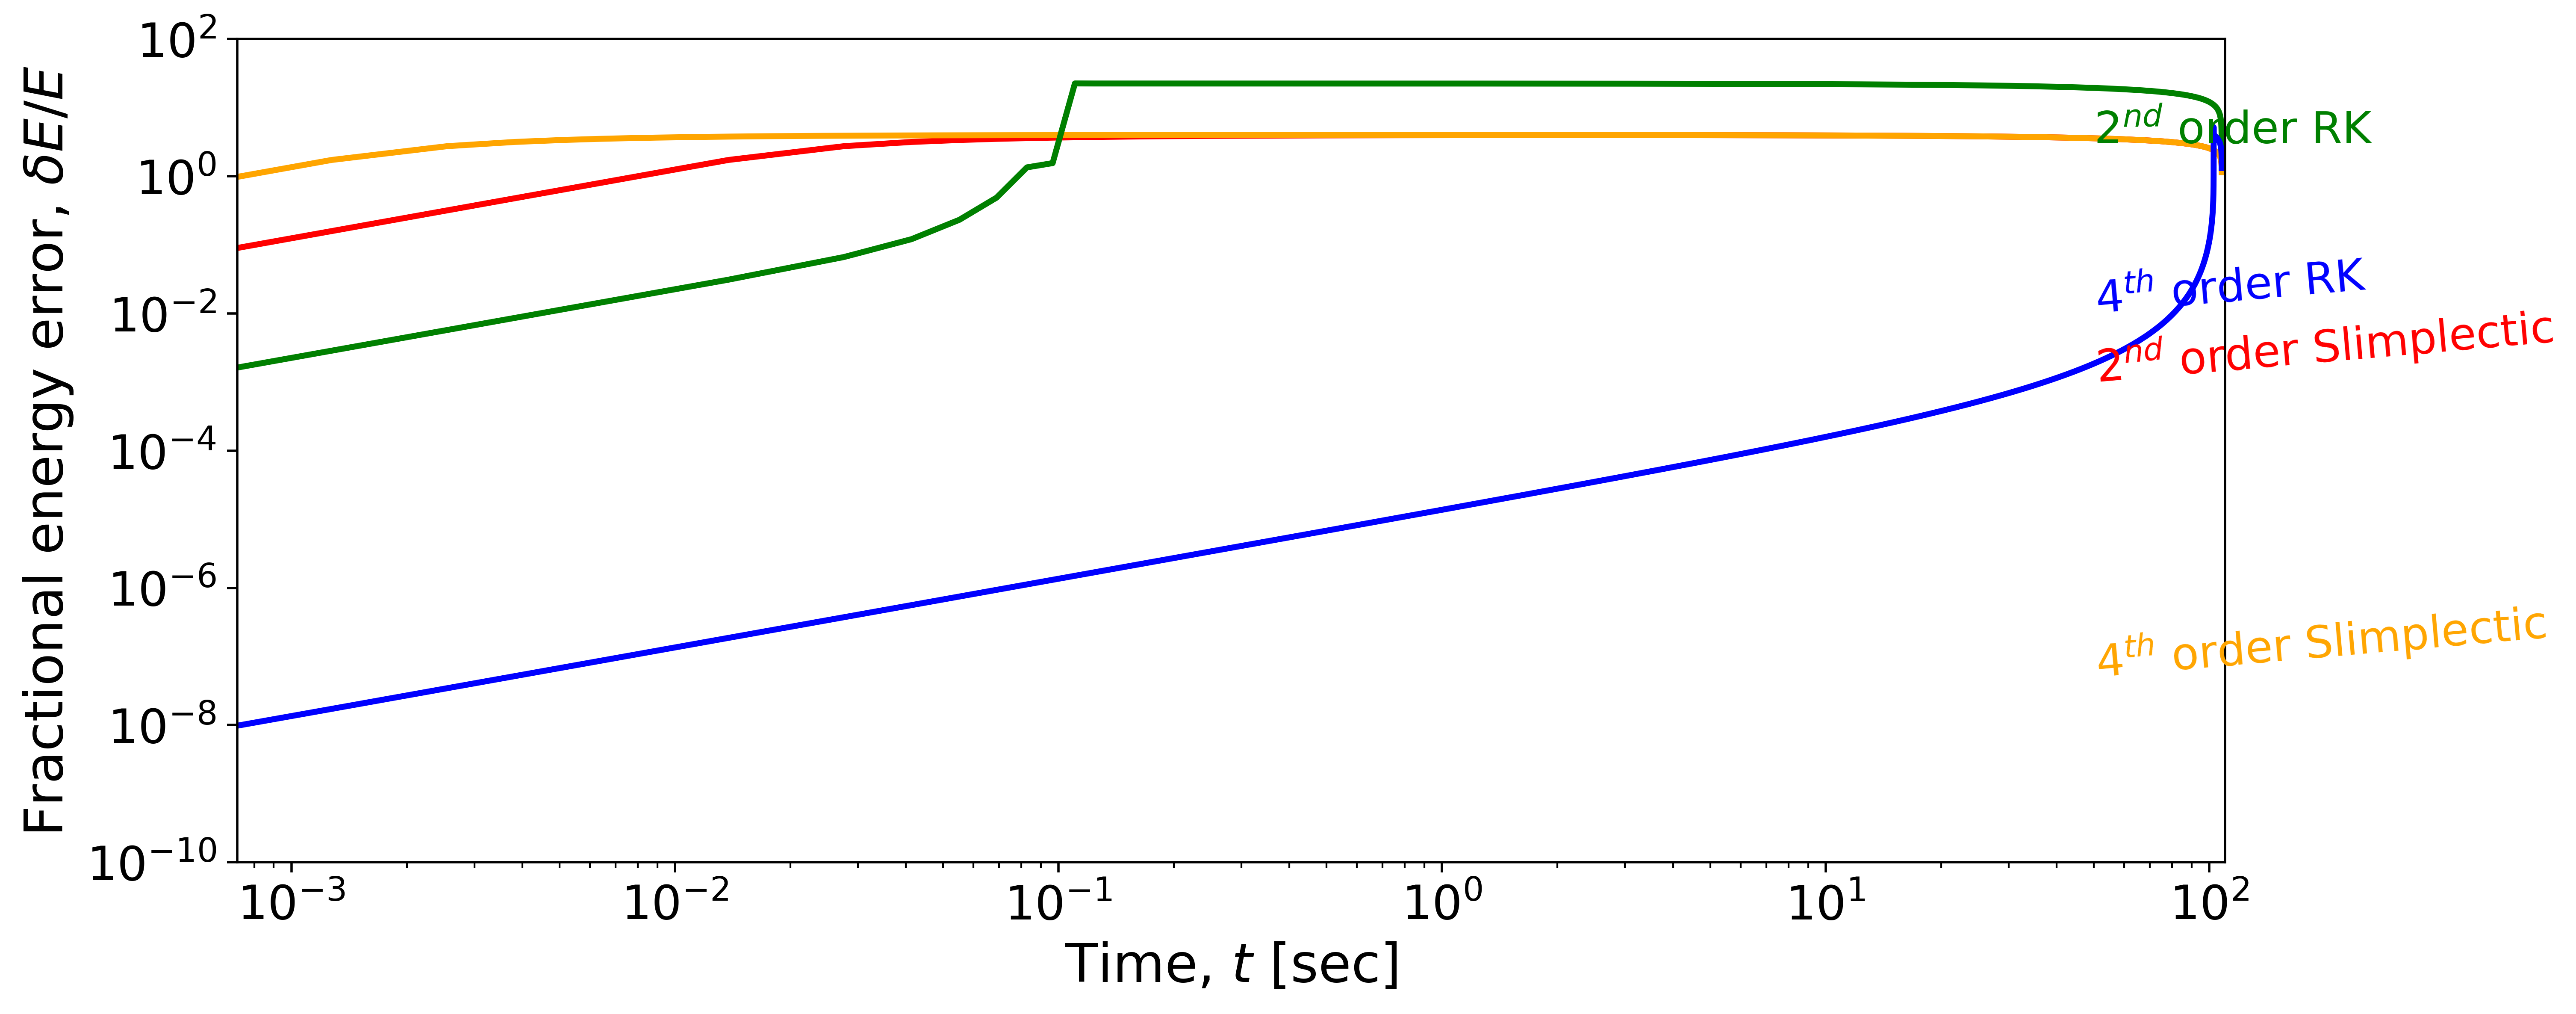

In [40]:
fig5 = plt.figure(figsize=(12, 5), dpi=500)

ax5 = fig5.add_subplot(1, 1, 1)

ax5.loglog(t_1000, np.abs(E_1000 / E_1000_ad - 1.), 'r-', linewidth=2.0, rasterized=True)
ax5.loglog(t_isco, np.abs(E_isco / E_isco_ad - 1.), color='orange', linestyle='-', linewidth=2.0, rasterized=True)
ax5.loglog(t_1000, np.abs(E_1000_rk4 / E_1000_ad - 1.), 'g-', linewidth=2.0, rasterized=True)
ax5.loglog(t_isco, np.abs(E_isco_rk4 / E_isco_ad - 1.), 'b-', linewidth=2.0, rasterized=True)

ax5.set_xlabel('Time, $t$ [sec]', fontsize=18)
ax5.set_ylabel('Fractional energy error, $\delta E/E$', fontsize=18)

ax5.text(50, 1e-3, r'$2^{nd}$ order Slimplectic', fontsize=15, color='r', rotation=5)
ax5.text(50, 5e-8, r'$4^{th}$ order Slimplectic', fontsize=15, color='orange', rotation=5)

ax5.text(50, 3e0, r'$2^{nd}$ order RK', fontsize=15, color='g', rotation=0)
ax5.text(50, 1e-2, r'$4^{th}$ order RK', fontsize=15, color='b', rotation=5)

ax5.tick_params(axis='both', which='major', labelsize=16)
ax5.set_ylim(1e-10, 1e2)
ax5.set_xlim(0, 1.02 * tcoal)
ax5.set_yticks([1e-10, 1e-8, 1e-6, 1e-4, 1e-2, 1e0, 1e2]);
